# Finding trending issues on the SF311 dataset

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## The time window to bucket samples
TIME_RANGE = '30min'

## File path
DATAPATH = "../SF311_simplified.csv"


#### Turn a raw CSV file into a time series we can model using some utils from moda

In [5]:
from moda.dataprep.raw_to_ts import raw_to_ts
from moda.dataprep.ts_to_range import ts_to_range

def raw_to_timeseries(datapath, time_range='30min', nrows=None, min_date=None, max_date=None, save_files=False):

    if nrows is None:
        raw = pd.read_csv(datapath, usecols=['Opened', 'Category'])
    else:
        raw = pd.read_csv(datapath, usecols=['Opened', 'Category'], nrows=nrows)

    raw = raw.rename(columns={'Opened': 'date', 'Category': 'category'})

    # Create a time series dataframe
    ts = raw_to_ts(raw, min_date=min_date, max_date=max_date)

    # Divide time series to ranges and categories
    ranged_ts = ts_to_range(ts, time_range=time_range)

    if save_files:
        if nrows is None:
            ts.to_csv("ts.csv")
            ranged_ts.to_csv("ranged_ts.csv")
        else:
            ts.to_csv("ts_" + str(nrows) + "_rows.csv")
            ranged_ts.to_csv("ranged_ts_" + str(nrows) + "_rows.csv")
    return ranged_ts

### Read a sample from the SF 311 data
Limiting the number of rows as this is a pretty big file

In [32]:
ranged_ts = raw_to_timeseries(DATAPATH,time_range=TIME_RANGE,nrows=1000000)

C:\ProgramData\Anaconda3\lib\site-packages\moda\dataprep\ts_to_range.py:17: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  range_grp = ts.groupby([pd.TimeGrouper(time_range), 'category']).agg('count')


#### A time series in moda has a MultiIndex, comprised of the date and the category.


In [33]:
print(len(ranged_ts))
print(ranged_ts.index.get_level_values('date').min())
print(ranged_ts.index.get_level_values('date').max())

print(ranged_ts.index.get_level_values('date').max() - ranged_ts.index.get_level_values('date').min())


470608
2008-07-01 00:00:00
2018-06-19 20:00:00
3640 days 20:00:00


In [ ]:
#Let's look which categories appear the most. We remove the index just for the EDA
flat = ranged_ts.reset_index()

#I'm using dfply because I like its functional-like syntax. This can also be done with plain pandas.
from dfply import *


min_values = 5000
min_days = 365

print("Original dataset contains {} categories.".format(len(flat['category'].unique())))


categories = flat >> group_by(X.category) >> \
    summarise(value = np.sum(X.value),duration_in_dataset = X.date.max()-X.date.min()) >> \
    ungroup() >> \
    mask(X.duration_in_dataset.dt.days > min_days) >> \
    mask(X.value > min_values) >> \
    arrange(X.value,ascending=False)



print("Filtered dataset contains {0} categories,\nafter filtering the small ones that existed less than {1} days or had {2} values of less.".
      format(len(categories),min_days,min_values))

categories.head(10)

## Most discussed categories

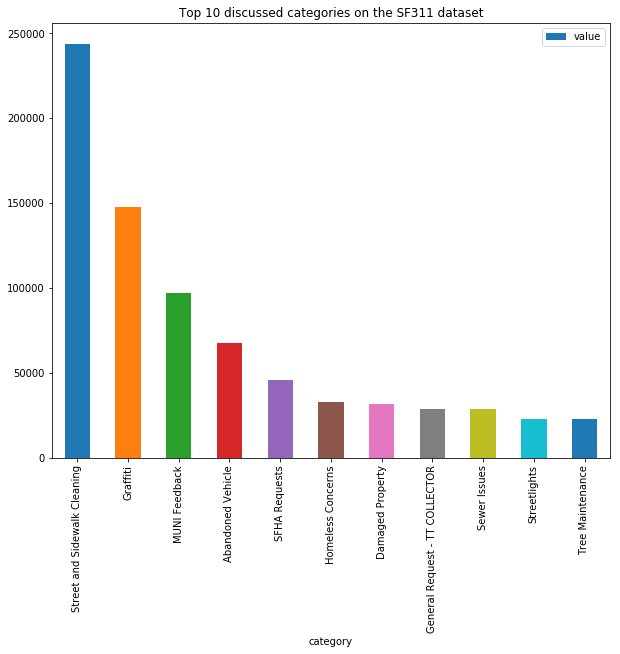

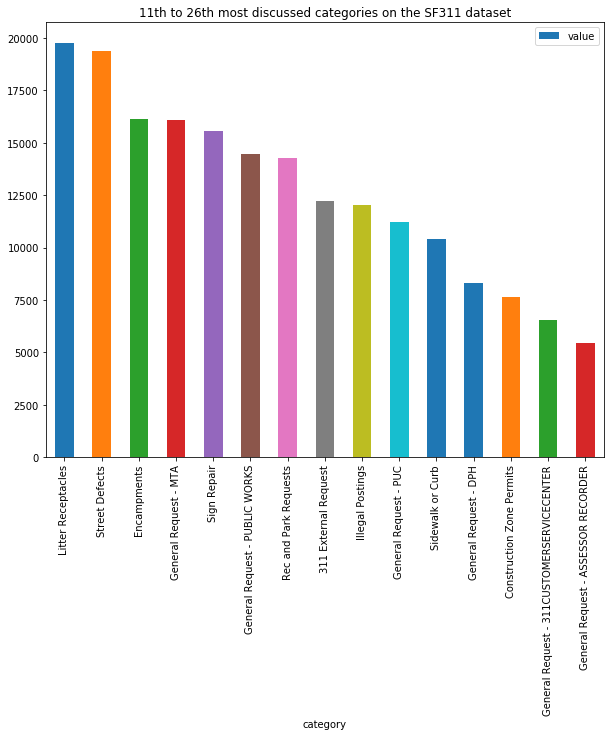

In [36]:
category_names = categories['category'].values
num_categories = len(categories)

major_category_threshold=11
major_categories = category_names[:major_category_threshold]
minor_categories = category_names[major_category_threshold:]


categories[categories['category'].isin(major_categories)].plot(kind='bar',x='category',y='value',title="Top "+str(major_category_threshold-1)+" discussed categories on the SF311 dataset",figsize=(10,8))
categories[categories['category'].isin(minor_categories)].plot(kind='bar',x='category',y='value',title=str(major_category_threshold)+"th to "+str(num_categories)+"th most discussed categories on the SF311 dataset",figsize=(10,8))

In [37]:
categories_yearly = flat >> mutate(year = X.date.dt.year) >> group_by(X.category,X.year) >> \
    summarise(value_per_year = np.sum(X.value),
              duration_in_dataset = X.date.max()-X.date.min()) >>\
    ungroup() >> \
    mask(X.value_per_year > (min_values/12.0)) >> \
    arrange(X.value_per_year,ascending=False)


categories_yearly.head()

,year,category,value_per_year,duration_in_dataset
524,2011,Street and Sidewalk Cleaning,51050,364 days 19:00:00
525,2012,Street and Sidewalk Cleaning,49217,365 days 18:30:00
523,2010,Street and Sidewalk Cleaning,42723,364 days 14:00:00
522,2009,Street and Sidewalk Cleaning,42167,364 days 13:00:00
526,2013,Street and Sidewalk Cleaning,38129,261 days 10:30:00


Text(0.5,1,'Yearly number of incidents for the top 10 categories')

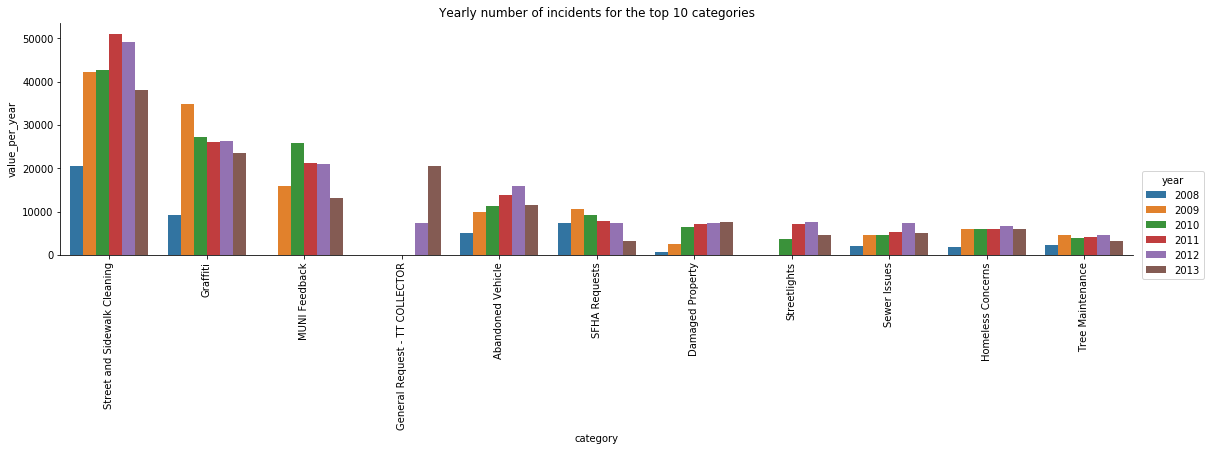

In [38]:
import seaborn as sns

major_cats_yearly = categories_yearly[categories_yearly['category'].isin(major_categories)]

g = sns.factorplot(x='category', y='value_per_year', hue='year', data=major_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the top "+str(major_category_threshold-1)+" categories")

Text(0.5,1,'Yearly number of incidents for the 11th to 26th categories')

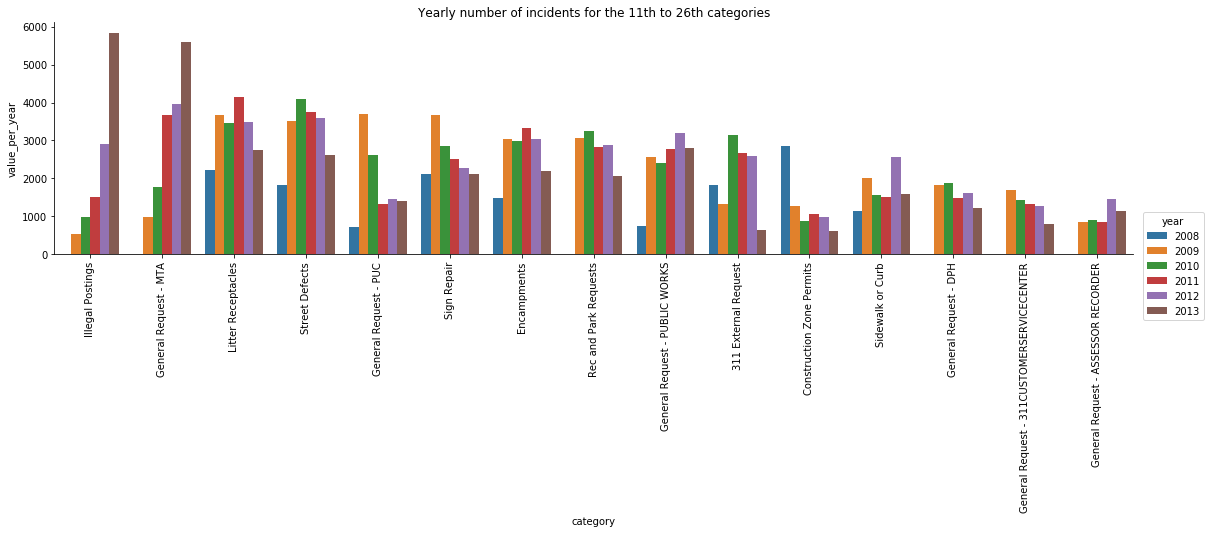

In [39]:
minor_cats_yearly = categories_yearly[categories_yearly['category'].isin(minor_categories)]


g = sns.factorplot(x='category', y='value_per_year', hue='year', data=minor_cats_yearly, kind='bar', size=4, aspect=4,legend=True)
g.set_xticklabels(rotation=90)
axes = g.axes.flatten()
axes[0].set_title("Yearly number of incidents for the "+str(major_category_threshold)+"th to "+str(num_categories)+"th categories")

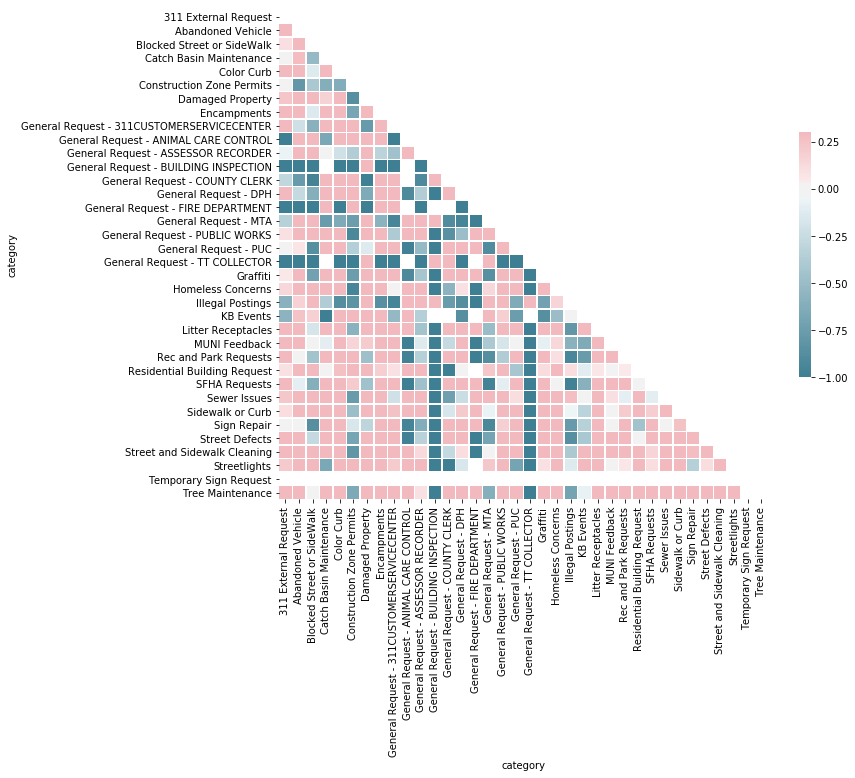

In [40]:
categories_yearly_pivot = categories_yearly.pivot("year", "category", "value_per_year")
categories_yearly_pivot.head()
corr = categories_yearly_pivot.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Time series inspection
### Selecting the biggest category, Street and Sidewalk Cleaning, just for inspection

In [41]:
street_cleaning = ranged_ts.loc[pd.IndexSlice[:, 'Street and Sidewalk Cleaning'], :].reset_index(level='category', drop=True)
# street_cleaning = street_cleaning[street_cleaning.index.get_level_values('date') < '2008-10-01']
street_cleaning.head()

,value
date,
2008-07-01 00:00:00,2
2008-07-01 03:00:00,1
2008-07-01 05:00:00,3
2008-07-01 06:00:00,6
2008-07-01 06:30:00,3


In [42]:
print(len(street_cleaning))
print(street_cleaning.index.get_level_values('date').min())
print(street_cleaning.index.get_level_values('date').max())

58913
2008-07-01 00:00:00
2018-06-18 09:00:00


### Time series plot

In [43]:
START = '2017-01-01'
END = '2017-06-01'
street_cleaning_flat = street_cleaning.reset_index()
street_cleaning_flat = street_cleaning_flat[(street_cleaning_flat['date'] > START) & (street_cleaning_flat['date']<=END)]
street_cleaning_flat.plot(kind='line',x='date',y='value',figsize=(40,7),linewidth=0.7, title = "Number of incidents per 30 minutes for Street and Sidewalk Cleaning")

TypeError: Empty 'DataFrame': no numeric data to plot

# Forecasting the next time range value using LSTMs
#### Train/Test split

In [ ]:
train_percent = 70
dates = street_cleaning_flat['date']
num_dates = len(dates)

train = street_cleaning_flat[:int(num_dates * train_percent / 100)]
test = street_cleaning_flat[int(num_dates * train_percent / 100):]

train_original = train.copy()
test_original = test.copy()

print("Training set length = {0}, Test set length = {1}".format(len(train),len(test)))

#### Pad train and test with zeros where dates are missing

In [ ]:
train = train.set_index('date').resample(TIME_RANGE, convention='start').asfreq().fillna(0)
test = test.set_index('date').resample(TIME_RANGE, convention='start').asfreq().fillna(0)
print("Training set length = {0}, Test set length = {1}".format(len(train),len(test)))

#### Scale values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))

scaled_values_train = scaler.fit_transform(train['value'].values.reshape(-1, 1))
train_scaled = pd.DataFrame(index = train.index)
train_scaled['value'] = scaled_values_train

scaled_values_test = scaler.fit_transform(test['value'].values.reshape(-1, 1))
test_scaled = pd.DataFrame(index = test.index)
test_scaled['value'] = scaled_values_test

print("Train length=" + str(len(train_scaled)))
train_scaled.head()

In [ ]:
# Prep series for modeling by creating windows of size window_size

window_size = 48*7

# Train
train_samples = train_scaled.copy()
for i in range(window_size):
    train_scaled = pd.concat([train_scaled,train_samples.shift(-(i+1))],axis=1)
train_scaled = train_scaled.dropna(axis=0)


# Test
test_samples = test_scaled.copy()
for i in range(window_size):
    test_scaled = pd.concat([test_scaled,test_samples.shift(-(i+1))],axis=1)
test_scaled = test_scaled.dropna(axis=0)

print("Train length={0}, Test length={1}".format(len(train_scaled),len(test_scaled)))

In [ ]:
train_scaled.head()

In [ ]:
test_scaled.head()

### Plot train and test time series

In [ ]:
train_original.reset_index().plot(kind='line',x='date',y='value',figsize=(20,4),linewidth=0.6, title = "Training set")

In [ ]:
test_original.reset_index().plot(kind='line',x='date',y='value',figsize=(13,4),linewidth=0.6, title = "Test set")

In [ ]:
train_X = train_scaled.iloc[:,:-1].values
train_y = train_scaled.iloc[:,-1].values
test_X = test_scaled.iloc[:,:-1].values
test_y = test_scaled.iloc[:,-1].values

test_dates = test_scaled.index

train_X = train_X.reshape(train_X.shape[0],train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1],1)

print("train_X dim={0}, train_y dim={1}, test_X dim={2}, test_y dim={3}".format(train_X.shape,train_y.shape,test_X.shape,test_y.shape))

In [ ]:
from comet_ml import Experiment
experiment = Experiment(api_key="Uv0lx3yRDH7kk8h1vtR9ZRiD2s16gnYTxfsvK2VnpV2xRrMbFobYDZRRA4tvoYiR",
                        project_name="keras-lstm-sf311-forecast", workspace="omri374")


from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers.core import Dense, Activation


model = Sequential()
#model.add(Conv1D(input_shape=(window_size, 1), filters=32, kernel_size=10))
#model.add(MaxPooling1D(pool_size=5))
model.add(LSTM(input_shape=(window_size, 1),output_dim=window_size, return_sequences=True))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="adam")
model.summary()

import time

from keras.callbacks import EarlyStopping

start = time.time()
model.fit(train_X,train_y,batch_size=256,epochs=10,validation_split=0.1,callbacks=[EarlyStopping(patience=2)])
print("> Compilation Time : ", time.time() - start)

# Doing a prediction on all the test data at once
preds = model.predict(test_X)

from sklearn.metrics import mean_squared_error

window = range(0,1800)


actual = test_y[window]
prediction = preds[window]

print("MSE="+str(mean_squared_error(actual,prediction)))
plt.figure(figsize=(20,10))
plt.plot(actual)
plt.plot(prediction)


experiment.log_parameter("window_size",window_size)
experiment.log_metric("MSE",mean_squared_error(test_y,preds))

### Anomaly detection by analyzing the difference between the forecasted sample and the real sample

In [ ]:
results = pd.DataFrame({"date":test_dates,"prediction" : preds.squeeze(),"actual" : test_y,"diff" : test_y - preds.squeeze()})
results['diff_rolling_std']=results['diff'].rolling(window=7*24*2, min_periods=10).std()
results['anomaly_3sd'] = np.where(results['diff'] > 3*results['diff_rolling_std'],1,0)
results['anomaly_4sd'] = np.where(results['diff'] > 4*results['diff_rolling_std'],1,0)
results['anomaly_5sd'] = np.where(results['diff'] > 5*results['diff_rolling_std'],1,0)

results.tail(20)


In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
fig.autofmt_xdate()

dates = results['date']


ax.plot(results.date, results.actual, label='Time series')
ax.plot(results.date, results.prediction, label='Forecast')



mask_3sd = (~np.isnan(results.anomaly_3sd)) & (results.anomaly_3sd != 0)
ax.plot_date(results.date[mask_3sd], results.actual[mask_3sd], marker='3', markersize=15, color='r', label='Anomaly 3 SD')

mask_4sd = (~np.isnan(results.anomaly_4sd)) & (results.anomaly_4sd != 0)
ax.plot_date(results.date[mask_4sd], results.actual[mask_4sd], marker='4', markersize=15,color='g', label='Anomaly 4 SD')

mask_5sd = (~np.isnan(results.anomaly_5sd)) & (results.anomaly_5sd != 0)
ax.plot_date(results.date[mask_5sd], results.actual[mask_5sd], marker='*', markersize=15, color='k',fillstyle="none", label='Anomaly 5 SD')
plt.title("LSTM anomaly detection results")
ax.legend(shadow=True, fancybox=True)
